In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install linearmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.6 MB/s eta 0:00:00


In [3]:
# Импорт необходимых библиотек
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# Настройка отображения графиков
%matplotlib inline
sns.set(style='whitegrid', rc={'figure.figsize': (15, 10)})

# Загрузка данных
data = pd.read_csv("/content/drive/MyDrive/NEW_ВКР 20.05.2024/russian_demography2023.csv")
data = data[(data.region != 'Sevastopol') & (data.region != 'Republic of Crimea')]
# Первые пять строк датасета
data.head()

,year,region,npg,birth_rate,death_rate,gdw,urbanization
0,1996,Republic of Adygea,1.9,14.2,12.3,84.66,52.42
1,1996,Altai Krai,1.8,12.9,11.1,80.24,58.07
2,1996,Amur Oblast,7.6,16.2,8.6,69.55,68.37
3,1996,Arkhangelsk Oblast,3.7,13.5,9.8,73.26,73.63
4,1996,Astrakhan Oblast,4.7,15.1,10.4,77.05,68.01


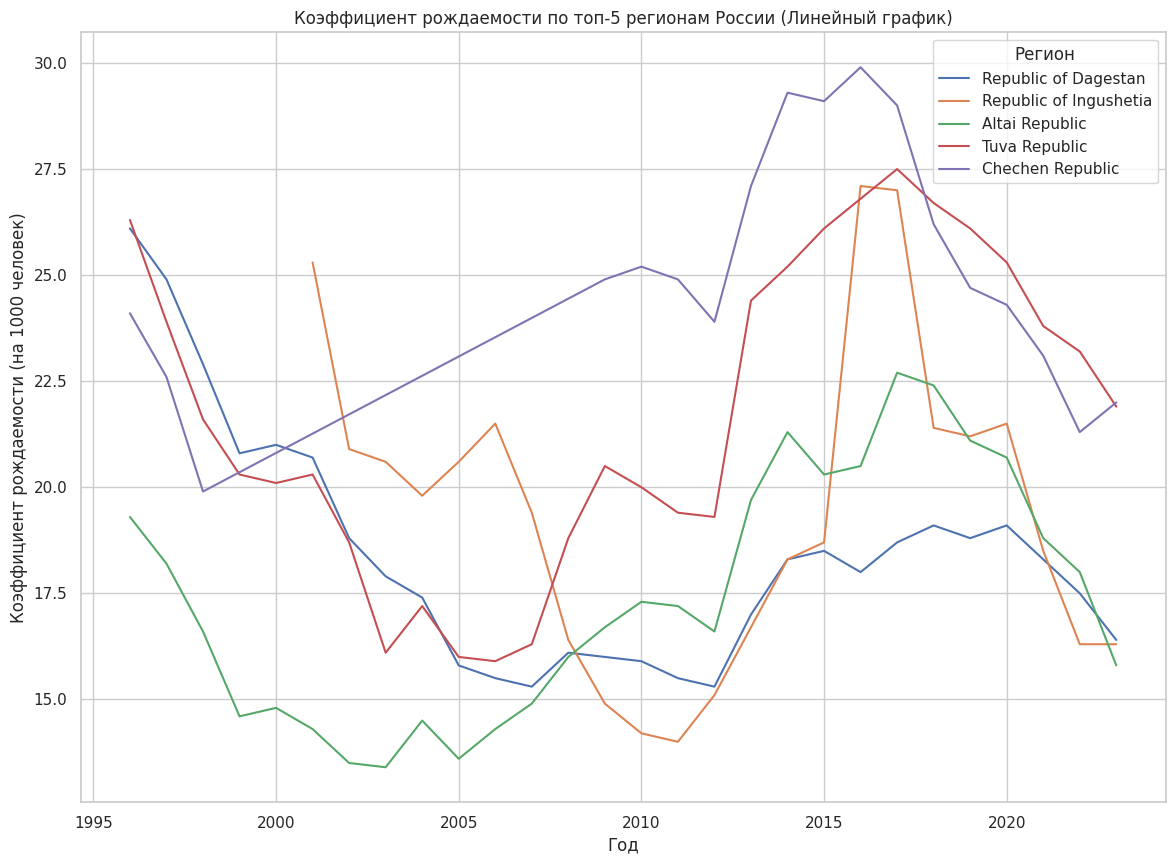

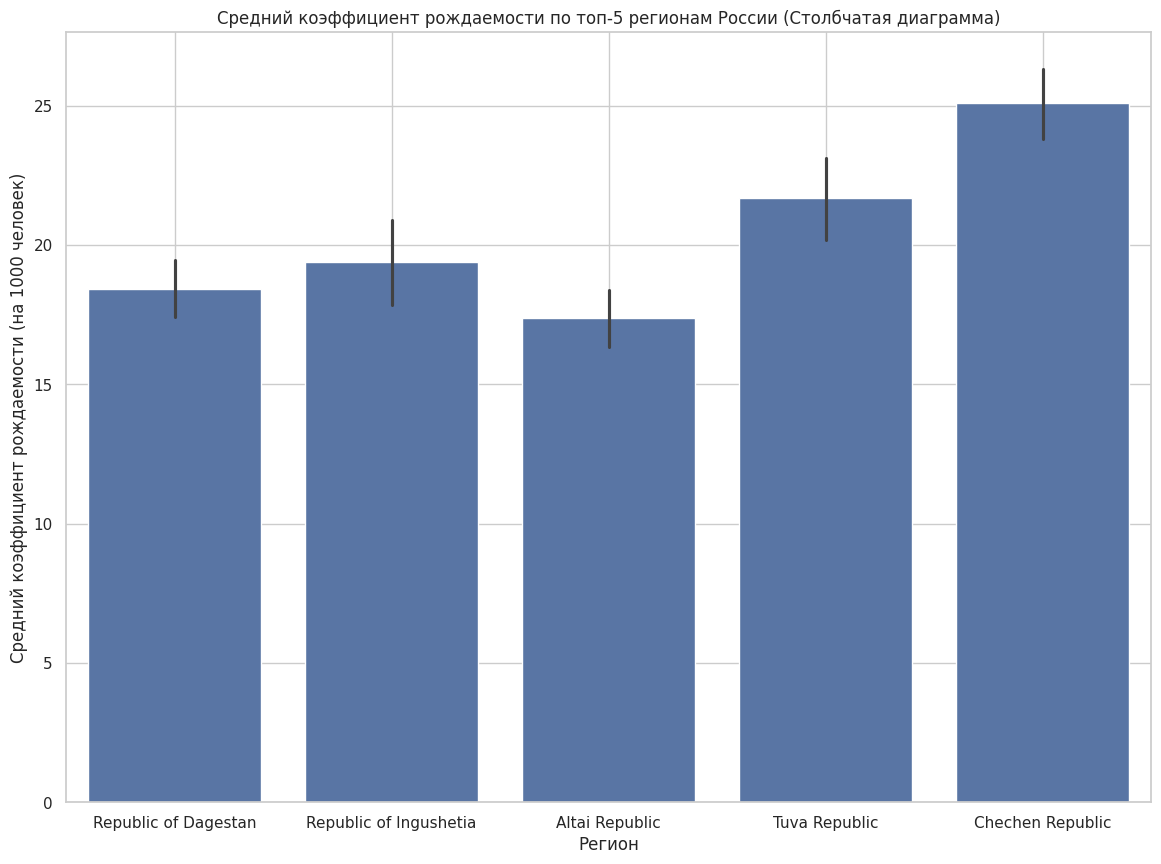

In [4]:
mean_birth_rate = data.groupby('region')['birth_rate'].mean().sort_values(ascending=False)

#Выбор топ 5 регионов с наибольшим средним коэффициентом рождаемости
top_5_regions = mean_birth_rate.head(5).index

# Фильтрация данных
top_5_data = data[data['region'].isin(top_5_regions)]

#Построение линейного графика
plt.figure(figsize=(14, 10))
sns.lineplot(x='year', y='birth_rate', hue='region', data=top_5_data)
plt.title('Коэффициент рождаемости по топ-5 регионам России (Линейный график)')
plt.xlabel('Год')
plt.ylabel('Коэффициент рождаемости (на 1000 человек)')
plt.legend(title='Регион', loc='upper right')
plt.grid(True)
plt.show()

#Построение столбчатой диаграммы
plt.figure(figsize=(14, 10))
sns.barplot(x='region', y='birth_rate', data=top_5_data, estimator=lambda x: sum(x) / len(x))
plt.title('Средний коэффициент рождаемости по топ-5 регионам России (Столбчатая диаграмма)')
plt.xlabel('Регион')
plt.ylabel('Средний коэффициент рождаемости (на 1000 человек)')
plt.grid(True)
plt.show()

Данные по Крыми и Севастополю исключены так как их слишком мало

In [5]:
def func1(group):
    cols = ['npg', 'birth_rate', 'death_rate', 'gdw', 'urbanization']
    group['next_birth_rate'] = group['birth_rate'].shift(-1)
    return group

indexed_df = data.groupby("region").apply(func1).reset_index(drop=True).dropna().set_index(['region', 'year'])

<Axes: >

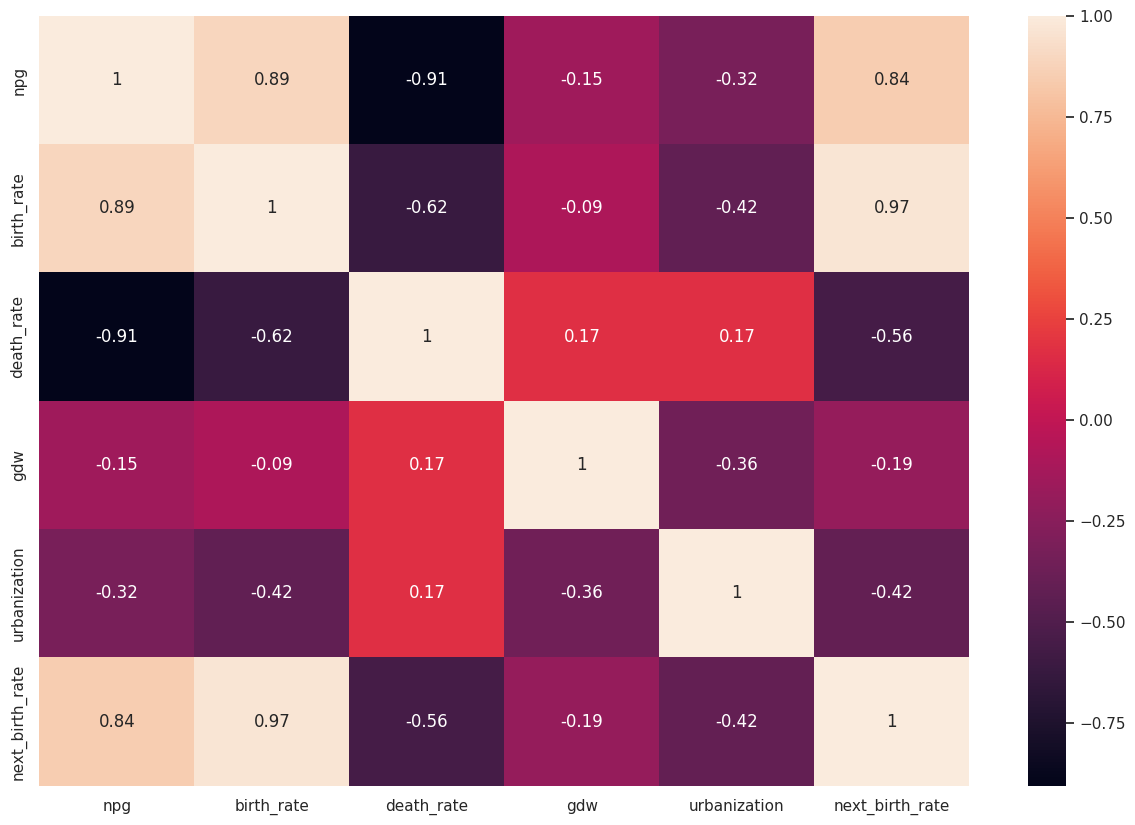

In [6]:
sns.heatmap(indexed_df.corr(), annot=True)

Задачей было предсказать рождаемость, поэтому целевая переменная в данном случае это коэффициент рождаемости в следующем году

In [7]:
indexed_df

npg  birth_rate  death_rate    gdw  urbanization  \
region           year                                                     
Altai Krai       1996  1.8        12.9        11.1  80.24         58.07   
                 1997  0.4        11.7        11.3  79.95         58.08   
                 1998 -1.4        10.4        11.8  79.55         55.21   
                 1999 -4.9         9.1        14.0  79.16         52.26   
                 2000 -5.9         9.2        15.1  78.21         52.06   
...                    ...         ...         ...    ...           ...   
Zabaykalsky Krai 2018  3.1        16.2        13.1  62.80         66.40   
                 2019  3.4        15.9        12.5  65.13         66.80   
                 2020  3.5        16.0        12.5  67.69         67.10   
                 2021  2.5        15.4        12.9  70.13         67.40   
                 2022  2.3        14.6        12.3  72.64         67.70   

                       next_birth_rate  
region           year                   
Altai Krai       1996             11.7  
                 1997             10.4  
                 1998              9.1  
                 1999              9.2  
                 2000              8.7  
...                                ...  
Zabaykalsky Krai 2018             15.9  
                 2019             16.0  
                 2020             15.4  
                 2021             14.6  
                 2022             13.4  

[2225 rows x 6 columns]

Ниже строится три модели: стандартная регерессия, модель со случайными эффектами и с фиксированными.

In [8]:
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from linearmodels import PooledOLS
from sklearn.metrics import mean_absolute_error, mean_squared_error
t = indexed_df
exog = sm.add_constant(t.drop('next_birth_rate', axis=1))
endog = t['next_birth_rate']

model_pool = PooledOLS(endog, exog)
pool_res = model_pool.fit()

model_re = RandomEffects(endog, exog)
re_res = model_re.fit()

model_fe = PanelOLS(endog, exog, entity_effects = True)
fe_res = model_fe.fit()

print(pool_res)
print()
print(re_res)
print()
print(fe_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:        next_birth_rate   R-squared:                        0.9574
Estimator:                  PooledOLS   R-squared (Between):              0.9935
No. Observations:                2225   R-squared (Within):               0.8789
Date:                Tue, May 21 2024   R-squared (Overall):              0.9574
Time:                        15:45:01   Log-likelihood                   -2212.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      9963.7
Entities:                          83   P-value                           0.0000
Avg Obs:                       26.807   Distribution:                  F(5,2219)
Min Obs:                       16.000                                           
Max Obs:                       27.000   F-statistic (robust):             9963.7
                            

Так как данные являются временным рядом, слудющее значение ряда силльно зависит от предыдущих показателей, для объективности оценки модели, необходимо предсказывать не следующее значение рождаемости, а его изменение. Поэтому ключевая переменная была модифицирована: предсказывалась не рождаемость а ее изменение.

<Axes: xlabel='year'>

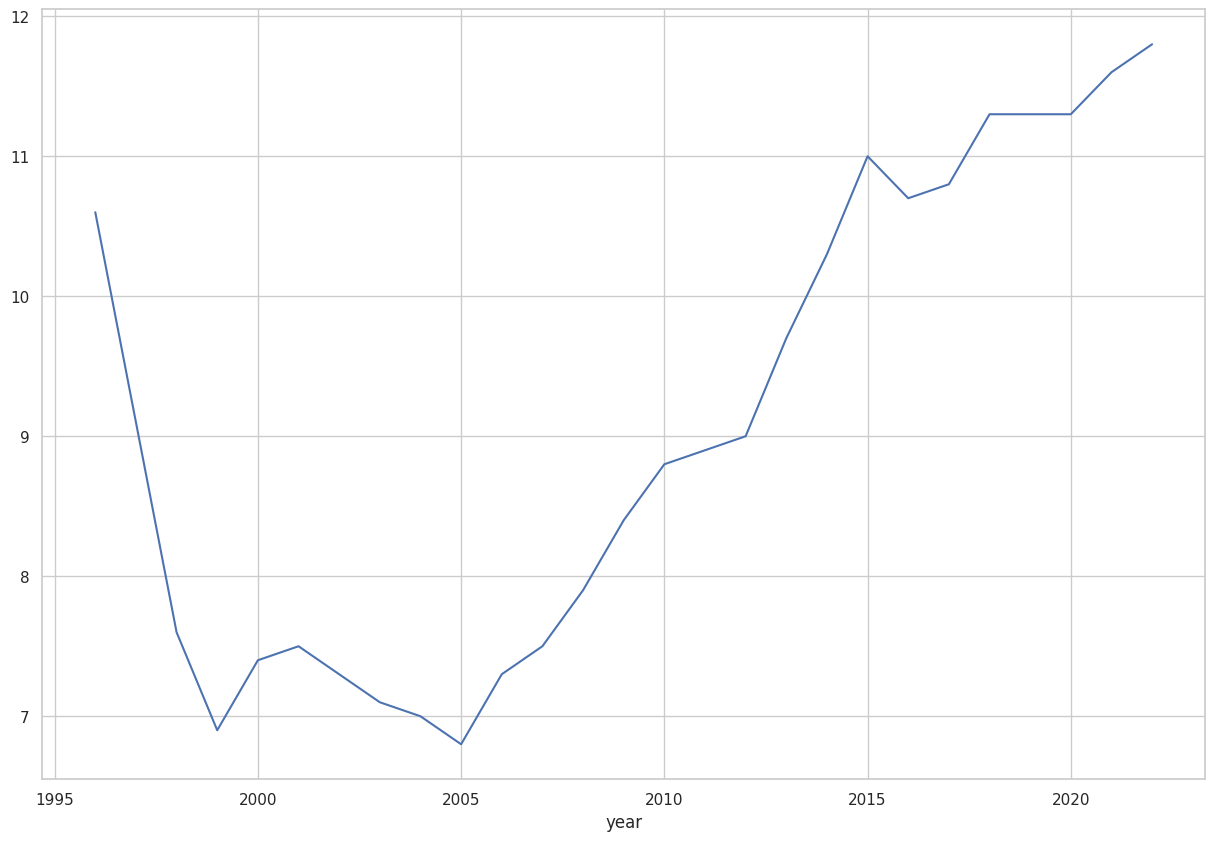

In [ ]:
indexed_df.loc['Moscow'].birth_rate.plot()

In [ ]:
def func(group):
    cols = ['npg', "birth_rate", 'death_rate', 'gdw', 'urbanization']
    group['next_birth_rate'] = group['birth_rate'].shift(-1) - group['birth_rate']
    # cols = ['npg', 'death_rate', 'gdw', 'urbanization']
    group[cols] = group[cols] - group[cols].shift(1)
    return group

In [ ]:
drop_cols = []
df_with_target = data.groupby("region").apply(func).reset_index(drop=True).dropna().set_index(['region', 'year']).drop(drop_cols, axis=1)

График изменения рождаемости на 1000 чел. в Москве

<Axes: xlabel='year', ylabel='next_birth_rate'>

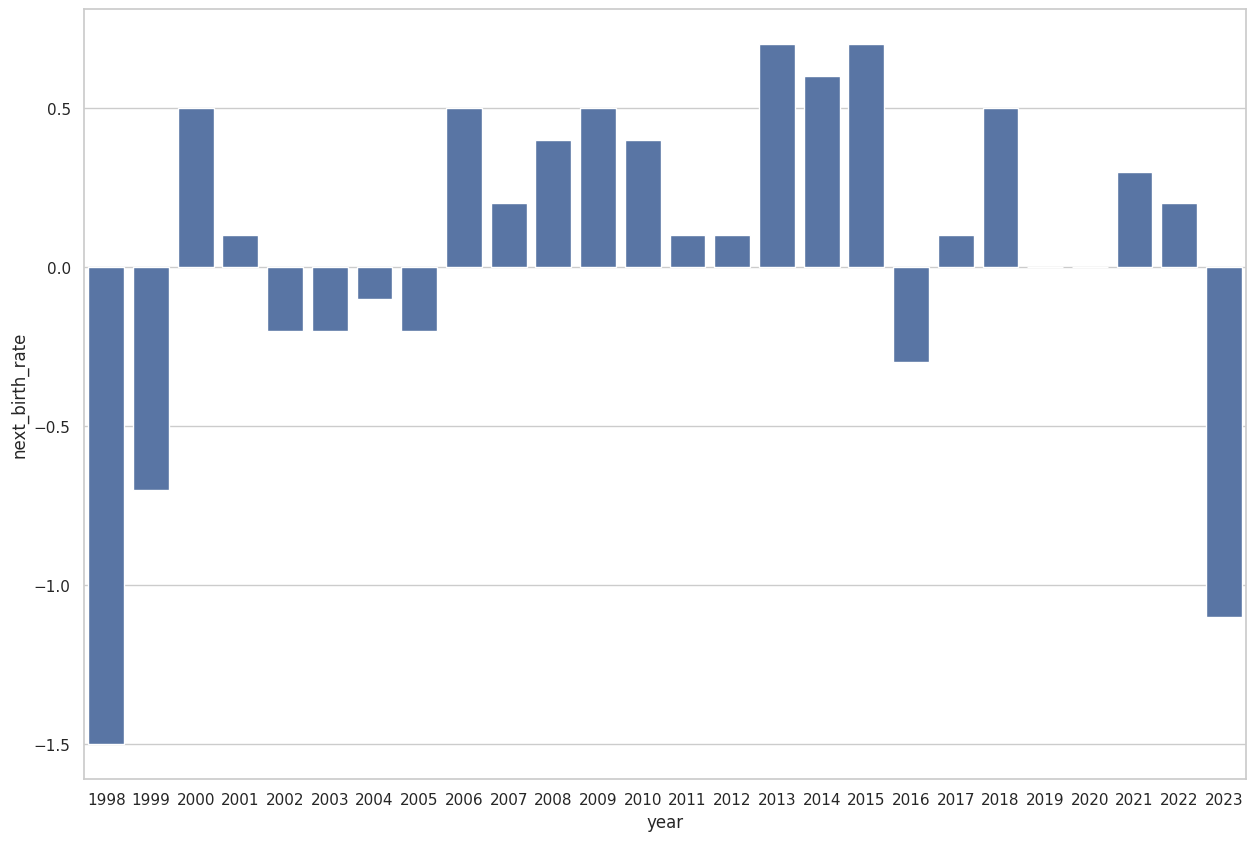

In [ ]:
t = df_with_target.loc['Moscow'].next_birth_rate
t.index +=1
sns.barplot(t)

In [ ]:
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from linearmodels import PooledOLS

In [ ]:
df_with_target

npg  birth_rate  death_rate   gdw  urbanization  \
region           year                                                    
Altai Krai       1997 -1.4        -1.2         0.2 -0.29          0.01   
                 1998 -1.8        -1.3         0.5 -0.40         -2.87   
                 1999 -3.5        -1.3         2.2 -0.39         -2.95   
                 2000 -1.0         0.1         1.1 -0.95         -0.20   
                 2001 -0.1        -0.5        -0.4 -1.06         -0.09   
...                    ...         ...         ...   ...           ...   
Zabaykalsky Krai 2018  0.9         0.7        -0.2  1.93          0.40   
                 2019  0.3        -0.3        -0.6  2.33          0.40   
                 2020  0.1         0.1         0.0  2.56          0.30   
                 2021 -1.0        -0.6         0.4  2.44          0.30   
                 2022 -0.2        -0.8        -0.6  2.51          0.30   

                       next_birth_rate  
region           year                   
Altai Krai       1997             -1.3  
                 1998             -1.3  
                 1999              0.1  
                 2000             -0.5  
                 2001             -0.3  
...                                ...  
Zabaykalsky Krai 2018             -0.3  
                 2019              0.1  
                 2020             -0.6  
                 2021             -0.8  
                 2022             -1.2  

[2141 rows x 6 columns]

In [ ]:
data.sort_values(['region', 'year'])

,year,region,npg,birth_rate,death_rate,gdw,urbanization
1,1996,Altai Krai,1.8,12.9,11.1,80.24,58.07
86,1997,Altai Krai,0.4,11.7,11.3,79.95,58.08
171,1998,Altai Krai,-1.4,10.4,11.8,79.55,55.21
256,1999,Altai Krai,-4.9,9.1,14.0,79.16,52.26
341,2000,Altai Krai,-5.9,9.2,15.1,78.21,52.06
...,...,...,...,...,...,...,...
1970,2019,Zabaykalsky Krai,3.4,15.9,12.5,65.13,66.80
2055,2020,Zabaykalsky Krai,3.5,16.0,12.5,67.69,67.10
2140,2021,Zabaykalsky Krai,2.5,15.4,12.9,70.13,67.40
2225,2022,Zabaykalsky Krai,2.3,14.6,12.3,72.64,67.70


In [ ]:
drop_cols = []
df_with_target = data.groupby("region").apply(func).reset_index(drop=True).dropna().drop(drop_cols, axis=1)
test, train = df_with_target[df_with_target['year'] == 2022], df_with_target[df_with_target['year'] != 2022]
train = train.set_index(['region', 'year'])
test = test.set_index(['region', 'year'])

exog = sm.add_constant(train.drop('next_birth_rate', axis=1))
endog = train['next_birth_rate']

model_pool = PooledOLS(endog, exog)
pool_res = model_pool.fit()

model_re = RandomEffects(endog, exog)
re_res = model_re.fit()

model_fe = PanelOLS(endog, exog, entity_effects = True)
fe_res = model_fe.fit()


print(pool_res)
print()
print(re_res)
print()
print(fe_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:        next_birth_rate   R-squared:                        0.1945
Estimator:                  PooledOLS   R-squared (Between):              0.3653
No. Observations:                2058   R-squared (Within):               0.1917
Date:                Mon, May 20 2024   R-squared (Overall):              0.1945
Time:                        19:11:15   Log-likelihood                   -2062.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      99.078
Entities:                          83   P-value                           0.0000
Avg Obs:                       24.795   Distribution:                  F(5,2052)
Min Obs:                       13.000                                           
Max Obs:                       25.000   F-statistic (robust):             99.078
                            

По результатам моделирования мы видим что, переменные рождаемости и урбанизации не значимы, поэтому в будущем необходимо их исключить из регрессии. Необходимость исключения этих переменных доказывает корреляционный анализ - рождаемость коррелирует с естественнным приростом, а естественный прирост по смертностью. Сметртност с рождаемостью коррелирует слабо поэтому удалим естественный прирост

In [ ]:
drop_cols = ['npg', 'urbanization']
df_with_target = data.groupby("region").apply(func).reset_index(drop=True).dropna().drop(drop_cols, axis=1)
test, train = df_with_target[df_with_target['year'] == 2022], df_with_target[df_with_target['year'] != 2022]
train = train.set_index(['region', 'year'])
test = test.set_index(['region', 'year'])

exog = sm.add_constant(train.drop('next_birth_rate', axis=1))
endog = train['next_birth_rate']

model_pool = PooledOLS(endog, exog)
pool_res = model_pool.fit()

model_re = RandomEffects(endog, exog)
re_res = model_re.fit()

model_fe = PanelOLS(endog, exog, entity_effects = True)
fe_res = model_fe.fit()


print(pool_res)
print()
print(re_res)
print()
print(fe_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:        next_birth_rate   R-squared:                        0.1915
Estimator:                  PooledOLS   R-squared (Between):              0.3636
No. Observations:                2058   R-squared (Within):               0.1888
Date:                Mon, May 20 2024   R-squared (Overall):              0.1915
Time:                        19:11:18   Log-likelihood                   -2066.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      162.21
Entities:                          83   P-value                           0.0000
Avg Obs:                       24.795   Distribution:                  F(3,2054)
Min Obs:                       13.000                                           
Max Obs:                       25.000   F-statistic (robust):             162.21
                            

Исключим так же константу и смертность как незначимые переменные

In [ ]:
data

,year,region,npg,birth_rate,death_rate,gdw,urbanization
0,1996,Republic of Adygea,1.9,14.2,12.3,84.66,52.42
1,1996,Altai Krai,1.8,12.9,11.1,80.24,58.07
2,1996,Amur Oblast,7.6,16.2,8.6,69.55,68.37
3,1996,Arkhangelsk Oblast,3.7,13.5,9.8,73.26,73.63
4,1996,Astrakhan Oblast,4.7,15.1,10.4,77.05,68.01
...,...,...,...,...,...,...,...
2375,2023,Chuvash Republic,-1.3,11.3,12.6,76.63,62.00
2376,2023,Chukotka Autonomous Okrug,3.7,13.1,9.4,58.23,70.00
2377,2023,Sakha (Yakutia) Republic,6.4,14.5,8.1,70.10,65.50
2378,2023,Yamalo-Nenets Autonomous Okrug,9.1,14.0,4.9,53.57,83.70


In [ ]:
drop_cols = ['npg', 'urbanization', 'death_rate']
df_with_target = data.groupby("region").apply(func).reset_index(drop=True).dropna().drop(drop_cols, axis=1)
test, train = df_with_target[df_with_target['year'] == 2022], df_with_target[df_with_target['year'] != 2022]
train = train.set_index(['region', 'year'])
test = test.set_index(['region', 'year'])

exog = train.drop('next_birth_rate', axis=1)
endog = train['next_birth_rate']

model_pool = PooledOLS(endog, exog)
pool_res = model_pool.fit()

model_re = RandomEffects(endog, exog)
re_res = model_re.fit()

model_fe = PanelOLS(endog, exog, entity_effects = True)
fe_res = model_fe.fit()


print(pool_res)
print()
print(re_res)
print()
print(fe_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:        next_birth_rate   R-squared:                        0.1909
Estimator:                  PooledOLS   R-squared (Between):              0.3902
No. Observations:                2058   R-squared (Within):               0.1878
Date:                Mon, May 20 2024   R-squared (Overall):              0.1909
Time:                        19:11:23   Log-likelihood                   -2067.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      242.59
Entities:                          83   P-value                           0.0000
Avg Obs:                       24.795   Distribution:                  F(2,2056)
Min Obs:                       13.000                                           
Max Obs:                       25.000   F-statistic (robust):             242.59
                            

In [ ]:
def eval(models, test, add_constant = False):
    res = []
    if add_constant:
      exog = sm.add_constant(test.drop('next_birth_rate', axis=1))
    else:
      exog = test.drop('next_birth_rate', axis=1)
    endog = test['next_birth_rate']
    for model in models:
        t = {"Model": repr(model)}
        predictions = model.predict(exog)
        t["MAE"]=  mean_absolute_error(endog, predictions)
        t["MSE"]=  mean_squared_error( endog, predictions)
        res.append(t)
    return pd.DataFrame(res)

In [ ]:
eval([pool_res,fe_res, re_res], test)

,Model,MAE,MSE
0,PooledOLS Estimation...,1.108408,1.380442
1,PanelOLS Estimation ...,1.100862,1.362290
2,RandomEffects Estimati...,1.108408,1.380442


Наилучшим образом данные объясняет регрессия с фиксированными эффектами.
Модель объясняет около 19,08% общей дисперсии в показателе next_birth_rate, что относительно скромно. Значимыми предикторами в модели являются birth_rate и gdw, оба из которых имеют ожидаемые знаки и являются статистически значимыми. Birth_rate оказывает положительное воздействие, в то время как gdw оказывает отрицательное воздействие на next_birth_rate.

F-тест на однородность данных предполагает, что объединение данных не является подходящим, что подтверждает решение использовать модель PanelOLS с учетом эффектов по сущностям. Это указывает на то, что существуют значительные различия между сущностями, которые необходимо учитывать в модели.

Эти результаты предполагают, что политика или факторы, влияющие на birth_rate и количество работоспособного населения (gdw), могут иметь значительное влияние на будущие уровни рождаемости. Отсутствие значимости для однородности данных указывает на то, что различия между сущностями важны и должны быть учтены в анализе.

Финальная модель

In [ ]:
drop_cols = ['npg', 'urbanization', 'death_rate']
df_with_target = data.groupby("region").apply(func).reset_index(drop=True).dropna().drop(drop_cols, axis=1).set_index(['region', 'year'])


exog = df_with_target.drop('next_birth_rate', axis=1)
endog = df_with_target['next_birth_rate']

model_pool = PooledOLS(endog, exog)
pool_res = model_pool.fit()

print(pool_res)


                          PooledOLS Estimation Summary                          
Dep. Variable:        next_birth_rate   R-squared:                        0.2236
Estimator:                  PooledOLS   R-squared (Between):              0.4213
No. Observations:                2141   R-squared (Within):               0.2207
Date:                Mon, May 20 2024   R-squared (Overall):              0.2236
Time:                        19:11:34   Log-likelihood                   -2225.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      308.07
Entities:                          83   P-value                           0.0000
Avg Obs:                       25.795   Distribution:                  F(2,2139)
Min Obs:                       14.000                                           
Max Obs:                       26.000   F-statistic (robust):             308.07
                            

In [ ]:
# exog[exog['year'] == 2023]
exog

birth_rate   gdw
region           year                  
Altai Krai       1997        -1.2 -0.29
                 1998        -1.3 -0.40
                 1999        -1.3 -0.39
                 2000         0.1 -0.95
                 2001        -0.5 -1.06
...                           ...   ...
Zabaykalsky Krai 2018         0.7  1.93
                 2019        -0.3  2.33
                 2020         0.1  2.56
                 2021        -0.6  2.44
                 2022        -0.8  2.51

[2141 rows x 2 columns]

In [ ]:
# endog,
exog.reset_index('year')

,year,birth_rate,gdw
region,,,
Altai Krai,1997,-1.2,-0.29
Altai Krai,1998,-1.3,-0.40
Altai Krai,1999,-1.3,-0.39
Altai Krai,2000,0.1,-0.95
Altai Krai,2001,-0.5,-1.06
...,...,...,...
Zabaykalsky Krai,2018,0.7,1.93
Zabaykalsky Krai,2019,-0.3,2.33
Zabaykalsky Krai,2020,0.1,2.56


In [ ]:
data

,year,region,npg,birth_rate,death_rate,gdw,urbanization
0,1996,Republic of Adygea,1.9,14.2,12.3,84.66,52.42
1,1996,Altai Krai,1.8,12.9,11.1,80.24,58.07
2,1996,Amur Oblast,7.6,16.2,8.6,69.55,68.37
3,1996,Arkhangelsk Oblast,3.7,13.5,9.8,73.26,73.63
4,1996,Astrakhan Oblast,4.7,15.1,10.4,77.05,68.01
...,...,...,...,...,...,...,...
2375,2023,Chuvash Republic,-1.3,11.3,12.6,76.63,62.00
2376,2023,Chukotka Autonomous Okrug,3.7,13.1,9.4,58.23,70.00
2377,2023,Sakha (Yakutia) Republic,6.4,14.5,8.1,70.10,65.50
2378,2023,Yamalo-Nenets Autonomous Okrug,9.1,14.0,4.9,53.57,83.70


In [ ]:
data[data['year'] == 2023]

,year,region,npg,birth_rate,death_rate,gdw,urbanization
2295,2023,Republic of Adygea,-2.0,10.6,12.6,80.22,47.3
2296,2023,Altai Krai,-3.2,10.8,14.0,83.61,56.3
2297,2023,Amur Oblast,-1.6,11.8,13.4,75.14,67.3
2298,2023,Arkhangelsk Oblast,-2.7,10.5,13.2,81.16,78.0
2299,2023,Astrakhan Oblast,0.7,12.1,11.4,78.19,66.5
...,...,...,...,...,...,...,...
2375,2023,Chuvash Republic,-1.3,11.3,12.6,76.63,62.0
2376,2023,Chukotka Autonomous Okrug,3.7,13.1,9.4,58.23,70.0
2377,2023,Sakha (Yakutia) Republic,6.4,14.5,8.1,70.10,65.5
2378,2023,Yamalo-Nenets Autonomous Okrug,9.1,14.0,4.9,53.57,83.7


Статистические тесты


In [ ]:
from linearmodels.panel import PooledOLS, compare
pooled_vs_re = compare({'Pooled OLS': pool_res, 'Random Effects': re_res})
print(pooled_vs_re)

                     Model Comparison                    
                             Pooled OLS    Random Effects
---------------------------------------------------------
Dep. Variable           next_birth_rate   next_birth_rate
Estimator                     PooledOLS     RandomEffects
No. Observations                   2141              2058
Cov. Est.                    Unadjusted        Unadjusted
R-squared                        0.2236            0.1909
R-Squared (Within)               0.2207            0.1878
R-Squared (Between)              0.4213            0.3902
R-Squared (Overall)              0.2236            0.1909
F-statistic                      308.07            242.59
P-value (F-stat)                 0.0000            0.0000
===================== ================= =================
birth_rate                       0.3911            0.3789
                               (20.373)          (20.234)
gdw                             -0.0997           -0.0600
              


Результаты сравнения моделей Pooled OLS и Random Effects показывают, что обе модели демонстрируют схожие показатели важных статистических метрик.

Обе модели имеют близнике значения коэффициентов для коэффициентов birth_rate и gdw, а также одинаковые статистические характеристики, такие как R-квадрат, F-статистика и их p-значения.

Это может означать, что обе модели достаточно хорошо подходят для описания данных и предсказания значения переменной next_birth_rate. Но все же с небольшим лидерством выигрывает модель МНК (OLS) с R^2 = 22.4%

In [ ]:

print(fe_res.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:        next_birth_rate   R-squared:                        0.1880
Estimator:                   PanelOLS   R-squared (Between):              0.3725
No. Observations:                2058   R-squared (Within):               0.1880
Date:                Mon, May 20 2024   R-squared (Overall):              0.1908
Time:                        19:11:23   Log-likelihood                   -2055.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      228.37
Entities:                          83   P-value                           0.0000
Avg Obs:                       24.795   Distribution:                  F(2,1973)
Min Obs:                       13.000                                           
Max Obs:                       25.000   F-statistic (robust):             228.37
                            

Интерпретация:
Чрезвычайно высокое значение p предполагает, что нам не удалось отвергнуть нулевую гипотезу. Это означает, что фиксированные эффекты существенно не отличаются от нуля, что указывает на отсутствие существенного преимущества в использовании модели с фиксированными эффектами перед объединенной моделью МНК.
На практике это означает, что рассмотрение всех объектов как однородных (игнорируя эффекты, специфичные для объекта) статистически оправдано.
Заключение:

Результаты F-теста на возможность объединения показывают, что объединение данных является целесообразным, и нет убедительных доказательств, подтверждающих необходимость модели с фиксированными эффектами для учета различий между конкретными организациями.
Учитывая эти результаты, можно использовать объединенную модель МНК без значительной потери информации, что упрощает анализ.

In [ ]:
data[data['year']==2023].isna().sum()

year            0
region          0
npg             0
birth_rate      0
death_rate      0
gdw             0
urbanization    0
dtype: int64

In [ ]:
data[data['region']=='Moscow'].set_index(['region', 'year']) - data[data['region']=='Moscow'].set_index(['region', 'year']).shift(1)

npg  birth_rate  death_rate   gdw  urbanization
region year                                                 
Moscow 1996  NaN         NaN         NaN   NaN           NaN
       1997 -1.5        -1.5         0.0 -0.78           0.0
       1998 -2.2        -1.5         0.7 -0.37           0.0
       1999 -3.3        -0.7         2.6  0.28           0.0
       2000 -0.3         0.5         0.8 -0.72           0.0
       2001  1.0         0.1        -0.9 -0.92           0.0
       2002  1.9        -0.2        -2.1 -2.04           0.0
       2003  0.6        -0.2        -0.8 -1.99           0.0
       2004  0.0        -0.1        -0.1 -2.05           0.0
       2005 -0.2        -0.2         0.0 -2.71           0.0
       2006  0.4         0.5         0.1 -2.39           0.0
       2007  0.1         0.2         0.1 -1.98           0.0
       2008  0.4         0.4         0.0 -1.40           0.0
       2009  0.6         0.5        -0.2 -1.16           0.0
       2010  0.9         0.4        -0.7 -0.43           0.0
       2011  0.4         0.1        -0.4  0.18           0.0
       2012  0.2         0.1        -0.3  0.35           0.0
       2013  1.0         0.7        -0.5  0.14           0.0
       2014  0.7         0.6         0.0  0.78           0.0
       2015  1.1         0.7        -0.5  0.98           0.0
       2016  0.1        -0.3         0.4  1.54           0.0
       2017  1.4         0.1        -1.3  0.89           0.0
       2018  0.3         0.5         0.2  5.10           0.0
       2019  0.3         0.0        -0.3 -1.38          -1.1
       2020 -0.1         0.0         0.1  2.05           0.0
       2021  0.1         0.3         0.2  2.30          -0.1
       2022  0.1         0.2         0.1  2.65           0.0
       2023 -0.7        -1.1        -0.4  2.42           0.0

In [ ]:
def func1(group):
    cols = ['npg', "birth_rate", 'death_rate', 'gdw', 'urbanization']
    # cols = ['npg', 'death_rate', 'gdw', 'urbanization']
    group[cols] = group[cols] - group[cols].shift(1)
    return group

In [ ]:
df_with_target = data.groupby("region").apply(func).reset_index(drop=True).dropna().drop(drop_cols, axis=1).set_index(['region'])
exog = sm.add_constant(df_with_target.drop('next_birth_rate', axis=1))
endog = df_with_target['next_birth_rate']
model = sm.OLS(endog, exog).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        next_birth_rate   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     254.3
Date:                Mon, 20 May 2024   Prob (F-statistic):          4.06e-141
Time:                        19:11:56   Log-Likelihood:                -2163.8
No. Observations:                2141   AIC:                             4336.
Df Residuals:                    2137   BIC:                             4358.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -62.0750      5.692    -10.906      0.0

In [ ]:
t = data.groupby("region").apply(func1).reset_index(drop=True).dropna().drop(drop_cols, axis=1).set_index(['region'])

In [ ]:
t2023 = t[t['year'] ==2023]

In [ ]:
preds = model.predict(sm.add_constant(t2023, has_constant='add'))

Предсказание модели

In [ ]:
(data[data.year==2023].set_index('region')['birth_rate'] + preds).head(30)

region
Altai Krai                               10.300112
Altai Republic                           15.152301
Amur Oblast                              11.489714
Arkhangelsk Oblast                       10.009321
Astrakhan Oblast                         11.506483
Belgorod Oblast                           9.265545
Bryansk Oblast                            9.109748
Chechen Republic                         22.477089
Chelyabinsk Oblast                       10.966290
Chukotka Autonomous Okrug                12.960698
Chuvash Republic                         10.715692
Irkutsk Oblast                           12.947128
Ivanovo Oblast                            9.346483
Jewish Autonomous Oblast                 11.205838
Kabardino-Balkar Republic                12.562514
Kaliningrad Oblast                       10.618957
Kaluga Oblast                            10.414302
Kamchatka Krai                           11.620053
Karachay-Cherkess Republic               10.860899
Kemerovo Oblast         

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_percentage_error, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression

In [ ]:
models = [(GradientBoostingRegressor, {'max_depth': 2}),
(RandomForestRegressor,),
(LinearRegression, ),
(MLPRegressor, {"hidden_layer_sizes":(5,5), "max_iter":1000, "n_iter_no_change":10, "learning_rate_init":1e-3, })]

In [ ]:
class EntityModels():
    def __init__(self, model, kwargs={}):
        self.model = model
        self.kwargs = kwargs

    def fit(self, X_train, Y_train):
        models = {}
        entities = X_train.index.unique()
        for entity in entities:
            model = self.model(**self.kwargs)
            # print(entity)
            # print(X_train.loc[entity].shape)
            # print(Y_train.shape)
            X_masked, Y_masked = X_train.loc[[entity]], Y_train.loc[[entity]]
            model.fit(X_masked, Y_masked)
            models[entity] = model
        self.models = models

    def predict(self, X):
        res = X.copy()
        entities = X.index.unique()
        output = []
        for entity in entities:
            X_masked = res.loc[[entity]]
            predictions = pd.Series(self.models[entity].predict(X_masked))
            predictions.name = 'pred'
            predictions.index = X_masked.index

            output.append(pd.concat([X_masked, predictions],axis=1))
        return pd.concat(output)


Этот класс EntityModels предназначен для создания индивидуальных по параметрам моделей машинного обучения для каждого региона

In [ ]:
def fit(regressors, X_train, X_test, Y_train, Y_test):
    res = []
    for model in regressors:
        model = EntityModels(*model)
        t = {"Model": repr(model.model)}
        # t = {'parameters': }
        model.fit(X_train, Y_train)
        print()
        predictions = model.predict(X_test)
        t["MAE"] =  mean_absolute_error(Y_test, predictions['pred'])
        t["MSE"] =  mean_squared_error(Y_test, predictions['pred'])
        res.append(t)
    return pd.DataFrame(res)


Сравнивать модели будем по показателю среднего отклонения и среднеквадратической ошибки

In [ ]:
t

,year,birth_rate,gdw
region,,,
Altai Krai,1997,-1.2,-0.29
Altai Krai,1998,-1.3,-0.40
Altai Krai,1999,-1.3,-0.39
Altai Krai,2000,0.1,-0.95
Altai Krai,2001,-0.5,-1.06
...,...,...,...
Zabaykalsky Krai,2019,-0.3,2.33
Zabaykalsky Krai,2020,0.1,2.56
Zabaykalsky Krai,2021,-0.6,2.44


In [ ]:
t = data.groupby("region").apply(func).reset_index(drop=True).dropna()
t = t.set_index('region')
test, train = t[t['year'] == 2022], t[t['year'] != 2022]
X_train, Y_train = train.drop('next_birth_rate', axis=1),  train['next_birth_rate']
X_test, Y_test = test.drop('next_birth_rate', axis=1),  test['next_birth_rate']

In [ ]:
models

[(sklearn.ensemble._gb.GradientBoostingRegressor, {'max_depth': 2}),
 (sklearn.ensemble._forest.RandomForestRegressor,),
 (sklearn.linear_model._base.LinearRegression,),
 (sklearn.neural_network._multilayer_perceptron.MLPRegressor,
  {'hidden_layer_sizes': (5, 5),
   'max_iter': 1000,
   'n_iter_no_change': 10,
   'learning_rate_init': 0.001})]

В сравнении учасвтуе несколько моделей: линейная регрессия, случайный лес, градиентный бустинг, нейронная сеть

In [ ]:
fit(models, X_train, X_test, Y_train, Y_test)

,Model,MAE,MSE
0,<class 'sklearn.ensemble._gb.GradientBoostingR...,1.167088,1.648111
1,<class 'sklearn.ensemble._forest.RandomForestR...,1.281964,1.872996
2,<class 'sklearn.linear_model._base.LinearRegre...,1.448047,2.320602
3,<class 'sklearn.neural_network._multilayer_per...,6.242482,136.935303


Наилучшим по точности оказалась линейная регрессия, но модель на панельных данных она не превосходит

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

class WalterraModel:
    def __init__(self):
        self.params = None

    def func(self, x, a, b, c, d, g):
        B, D = x['birth_rate'], x['death_rate']
        dB = a * B + b * B * D + g * D
        dD = c * D + d * B * D
        return np.array([dB, dD]).reshape(-1)

    def fit(self, data_t, data_shift):
        def model_func(x, a, b, c, d, g):
            return self.func({'birth_rate': x[::2], 'death_rate': x[1::2]}, a, b, c, d, g)

        popt, _ = curve_fit(model_func, data_t.values.flatten(), data_shift.values.flatten(), method='lm')
        self.params = popt

    def predict(self, data):
        return self.func(data, *self.params)


class EntityModelsWalterra:
    def __init__(self, model):
        self.model_class = model
        self.models = {}

    def fit(self, X_train, Y_train):
        entities = X_train.index.unique()
        for entity in entities:
            model = self.model_class()
            X_masked = X_train.loc[[entity]]
            Y_masked = Y_train.loc[[entity]]
            model.fit(X_masked, Y_masked)
            self.models[entity] = model

    def predict(self, X):
        output = []
        entities = X.index.unique()
        for entity in entities:
            model = self.models.get(entity)
            if model:
                X_masked = X.loc[[entity]]
                predictions = model.predict(X_masked)
                predictions_df = pd.DataFrame(predictions.reshape(-1, 2), columns=['dB', 'dD'], index=X_masked.index)
                output.append(pd.concat([X_masked, predictions_df], axis=1))
        res = pd.concat(output)
        res.index = X.index
        return res

t = data[data.year < 2023].set_index(['region', 'year'])
def func2(df):
  df[['dB', 'dD']] = df[['birth_rate', 'death_rate']].shift(-1)-df[['birth_rate', 'death_rate']]
  return df

t = data.groupby('region').apply(func2).dropna().set_index('region')
data_t = t[['birth_rate', 'death_rate']]
data_shift = t[['dB', 'dD']]
# Инициализируем и обучаем модель
model = WalterraModel()
model.fit(data_t, data_shift)

# Прогнозируем значения
predictions = model.predict(data_t).reshape(2,-1)
print(len(predictions))
pd.DataFrame(predictions).T

2


,0,1
0,-0.018649,-0.028727
1,-0.011092,-0.027229
2,-0.002502,-0.026154
3,0.008639,-0.028325
4,0.009036,-0.030775
...,...,...
2220,-0.044405,-0.040328
2221,-0.040834,-0.037923
2222,-0.041537,-0.038109
2223,-0.038134,-0.038178


In [ ]:
entity = t.loc["Altai Krai"]
entity
data_t = entity[['birth_rate', 'death_rate']]
data_shift = entity[['dB', 'dD']]
model = WalterraModel()
model.fit(data_t, data_shift)

In [ ]:
predictions = pd.DataFrame(model.predict(data_t).reshape(-1, 2), columns=['dB', 'dD'], index=entity.index)

In [ ]:
mean_absolute_error(entity[['dB']], predictions.iloc[:, 0])

0.4170033900891731

In [ ]:
mean_squared_error(entity[['dB']], predictions.iloc[:, 0])

0.3145498156325971

In [ ]:
w_model =EntityModelsWalterra(WalterraModel)

In [ ]:
t = data.groupby('region').apply(func2).dropna().set_index('region')
data_t = t[['birth_rate', 'death_rate']]
data_shift = t[['dB', 'dD']]
w_model.fit(data_t, data_shift)

In [ ]:
t

,year,npg,birth_rate,death_rate,gdw,urbanization,dB,dD
region,,,,,,,,
Altai Krai,1996,1.8,12.9,11.1,80.24,58.07,-1.2,0.2
Altai Krai,1997,0.4,11.7,11.3,79.95,58.08,-1.3,0.5
Altai Krai,1998,-1.4,10.4,11.8,79.55,55.21,-1.3,2.2
Altai Krai,1999,-4.9,9.1,14.0,79.16,52.26,0.1,1.1
Altai Krai,2000,-5.9,9.2,15.1,78.21,52.06,-0.5,-0.4
...,...,...,...,...,...,...,...,...
Zabaykalsky Krai,2018,3.1,16.2,13.1,62.80,66.40,-0.3,-0.6
Zabaykalsky Krai,2019,3.4,15.9,12.5,65.13,66.80,0.1,0.0
Zabaykalsky Krai,2020,3.5,16.0,12.5,67.69,67.10,-0.6,0.4


In [ ]:
data.groupby('region').apply(func2).dropna()

year            region  npg  birth_rate  death_rate  \
region                                                                       
Altai Krai       1     1996        Altai Krai  1.8        12.9        11.1   
                 86    1997        Altai Krai  0.4        11.7        11.3   
                 171   1998        Altai Krai -1.4        10.4        11.8   
                 256   1999        Altai Krai -4.9         9.1        14.0   
                 341   2000        Altai Krai -5.9         9.2        15.1   
...                     ...               ...  ...         ...         ...   
Zabaykalsky Krai 1885  2018  Zabaykalsky Krai  3.1        16.2        13.1   
                 1970  2019  Zabaykalsky Krai  3.4        15.9        12.5   
                 2055  2020  Zabaykalsky Krai  3.5        16.0        12.5   
                 2140  2021  Zabaykalsky Krai  2.5        15.4        12.9   
                 2225  2022  Zabaykalsky Krai  2.3        14.6        12.3   

                         gdw  urbanization   dB   dD  
region                                                
Altai Krai       1     80.24         58.07 -1.2  0.2  
                 86    79.95         58.08 -1.3  0.5  
                 171   79.55         55.21 -1.3  2.2  
                 256   79.16         52.26  0.1  1.1  
                 341   78.21         52.06 -0.5 -0.4  
...                      ...           ...  ...  ...  
Zabaykalsky Krai 1885  62.80         66.40 -0.3 -0.6  
                 1970  65.13         66.80  0.1  0.0  
                 2055  67.69         67.10 -0.6  0.4  
                 2140  70.13         67.40 -0.8 -0.6  
                 2225  72.64         67.70 -1.2 -0.6  

[2225 rows x 9 columns]

In [ ]:
def func2(df):
  df[['dB', 'dD']] = df[['birth_rate', 'death_rate']].shift(-1)-df[['birth_rate', 'death_rate']]
  return df

t = data.groupby('region').apply(func2).dropna().set_index('region')
t = t[t['year']==2022]
data_t = t[['birth_rate', 'death_rate']]
data_shift = t[['dB', 'dD']]
w_model.predict(data_t)

,birth_rate,death_rate,dB,dD
region,,,,
Altai Krai,12.1,14.1,0.157447,-0.212589
Altai Republic,18.0,9.9,0.224290,-0.269889
Amur Oblast,12.9,13.7,0.164494,-0.178648
Arkhangelsk Oblast,11.8,13.7,0.232331,-0.237074
Astrakhan Oblast,14.0,12.0,0.136941,-0.297876
...,...,...,...,...
Vologda Oblast,13.3,15.0,0.400815,-0.366488
Voronezh Oblast,10.7,15.2,0.129715,-0.307729
Yamalo-Nenets Autonomous Okrug,15.4,5.3,0.105344,-0.237597


In [ ]:
mean_absolute_error(data_shift['dB'], w_model.predict(data_t)['dB'])

1.5869563358915837

In [ ]:
mean_squared_error(data_shift['dB'], w_model.predict(data_t)['dB'])

2.7194177068031844